<a href="https://colab.research.google.com/github/agustin-ammazzagatti/ICARO-trabajo-practico-nro-4/blob/main/Sprint_3_Clustering___Data_Science_ICARO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico: Clustering

## 1. Introducción
El equipo de Marketing de la compañía utiliza regularmente campañas de mailing para interactuar con sus clientes potenciales. Se le consulta al equipo de Data Science si puede identificar segmentos de clientes de acuerdo a su interacción con la publicidad via correo electrónico. ¿Existen grupos según su comportamiento? ¿Se presenta algún patrón útil?


La idea es que puedan interpretar y analizar los datos, detectar algun patrón, crear nuevos atributos y entrenar un modelo que permita segmentar a los usuarios.

Es necesario analizar los clusters finales y poder caracterizarlos, pudiendo identificar cualidades particulares de cada uno.

El análisis no tiene límites, podés extenderte lo que consideres.

## 2. Exploración y Preparación de los Datos

### 2.1 Carga del Dataset

In [ ]:
# librerías para manipulación y análisis de datos
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# carga de datos
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Diplomatura ICARO/Sprint 3 - TP 1 (Clustering)/clustering_mailing.xlsx")

### 2.2 Descripción de variables

| Columna      | Descripción breve                                                           | Aclaración / Interpretación adicional                                                                 |
|--------------|------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------|
| Id           | Identificador único de cada usuario.                                        | No se repite entre filas. Cada registro corresponde a un usuario distinto.                            |
| send         | Número total de correos enviados al usuario.                                | Incluye todos los envíos, sin importar si fueron abiertos o no.                                       |
| bounce       | Número de correos rebotados (no entregados).                                | Recuento de correos que no llegaron por fallos como email inválido o bandeja llena.                   |
| open         | Número de veces que el usuario abrió correos.                               | Un usuario puede abrir un mismo correo varias veces. No implica clics.                                |
| click        | Número de veces que el usuario hizo clic en enlaces dentro de correos.      | Cuenta clics en cualquier enlace. Puede haber múltiples clics por correo o clics sin haber abierto.   |
| total        | Suma de send, bounce, open y click para ese usuario.                        | Puede no coincidir perfectamente en algunos registros; verificar consistencia antes de usar.           |
| comprador    | 1 si el usuario realizó al menos una compra, 0 si no compró nunca.          | Variable binaria. Puede usarse como objetivo en modelos de predicción (target).                       |
| hour         | Hora promedio del día en que el usuario interactuó -ya sea aperturas o clicks dentro de los mismos- con los correos.         | Valor entre 0 y 23, con decimales. Representa el promedio ponderado de las horas de interacción.      |
| day_of_week  | Día promedio de la semana de interacción -ya sea aperturas o clicks dentro de los mismos-.          | Valor continuo entre 0 y 6 -> 0 = lunes, 6 = domingo. Indica el día medio de actividad; por ejemplo, 2.5 ≈ martes/miércoles.    |

### 2.3 Análisis exploratorio

In [ ]:
# mostrar las primeras 5 filas del dataset
df.head()

,Id,send,bounce,open,click,Total,Comprador,hour,day_of_week
0,2044163,4,0,0,0,4,0,17.000000,3.500000
1,633731,1,0,0,0,1,0,21.000000,4.000000
2,1537126,4,0,0,0,4,0,17.000000,3.500000
3,1960135,3,0,0,0,3,0,15.333333,3.333333
4,1004992,8,0,1,0,10,1,18.222222,2.000000


In [ ]:
# mostrar 5 filas aleatorias del dataset
df.sample(n=5, random_state=42)

,Id,send,bounce,open,click,Total,Comprador,hour,day_of_week
146155,1402458,7,0,0,0,7,1,20.428571,1.857143
96736,1470949,1,1,0,0,3,0,11.500000,2.500000
197140,657711,1,0,0,0,1,1,21.000000,4.000000
43014,1518907,6,0,0,0,6,0,17.000000,3.000000
166192,494521,2,0,0,0,2,1,21.000000,4.000000


In [ ]:
# información general del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212292 entries, 0 to 212291
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Id           212292 non-null  int64  
 1   send         212292 non-null  int64  
 2   bounce       212292 non-null  int64  
 3   open         212292 non-null  int64  
 4   click        212292 non-null  int64  
 5   Total        212292 non-null  int64  
 6   Comprador    212292 non-null  int64  
 7   hour         212292 non-null  float64
 8   day_of_week  212292 non-null  float64
dtypes: float64(2), int64(7)
memory usage: 14.6 MB


- No se visualizan valores faltantes/nulos
- Se tendrá en cuenta el tipo de dato de las columnas "hour" y "day_of_week" si en un futuro se requieren para el análisis. Por el momento está correcto que figure como tipo de dato float

In [ ]:
# cantidad de filas y columnas del dataset
print("Cantidad de filas:", df.shape[0])
print("Cantidad de columnas:", df.shape[1])

Cantidad de filas: 212292
Cantidad de columnas: 9


In [ ]:
# listado de las columnas del dataset
df.columns

Index(['Id', 'send', 'bounce', 'open', 'click', 'Total', 'Comprador', 'hour',
       'day_of_week'],
      dtype='object')

In [ ]:
# estadística descriptiva de las variables numéricas
df.describe()

,Id,send,bounce,open,click,Total,Comprador,hour,day_of_week
count,2.122920e+05,212292.000000,212292.000000,212292.000000,212292.000000,212292.000000,212292.000000,212292.000000,212292.000000
mean,1.062074e+06,3.757801,0.264273,0.483819,0.072108,4.680077,0.616542,18.506052,2.467164
std,6.119871e+05,3.838834,0.665326,1.564734,0.607759,4.964009,0.486229,3.078170,1.208796
min,0.000000e+00,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,5.336052e+05,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,17.000000,1.500000
50%,1.062491e+06,2.000000,0.000000,0.000000,0.000000,3.000000,1.000000,19.600000,2.333333
75%,1.592284e+06,5.000000,0.000000,0.000000,0.000000,6.000000,1.000000,20.666667,3.500000
max,2.122907e+06,167.000000,55.000000,174.000000,106.000000,390.000000,1.000000,23.000000,6.000000


In [ ]:
# verificar si hay valores faltantes (nulos) en el dataset
df.isnull().sum()

,0
Id,0
send,0
bounce,0
open,0
click,0
Total,0
Comprador,0
hour,0
day_of_week,0


📊 Distribución de variables principales (send, open, click, bounce)

In [ ]:
# Configuración general
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

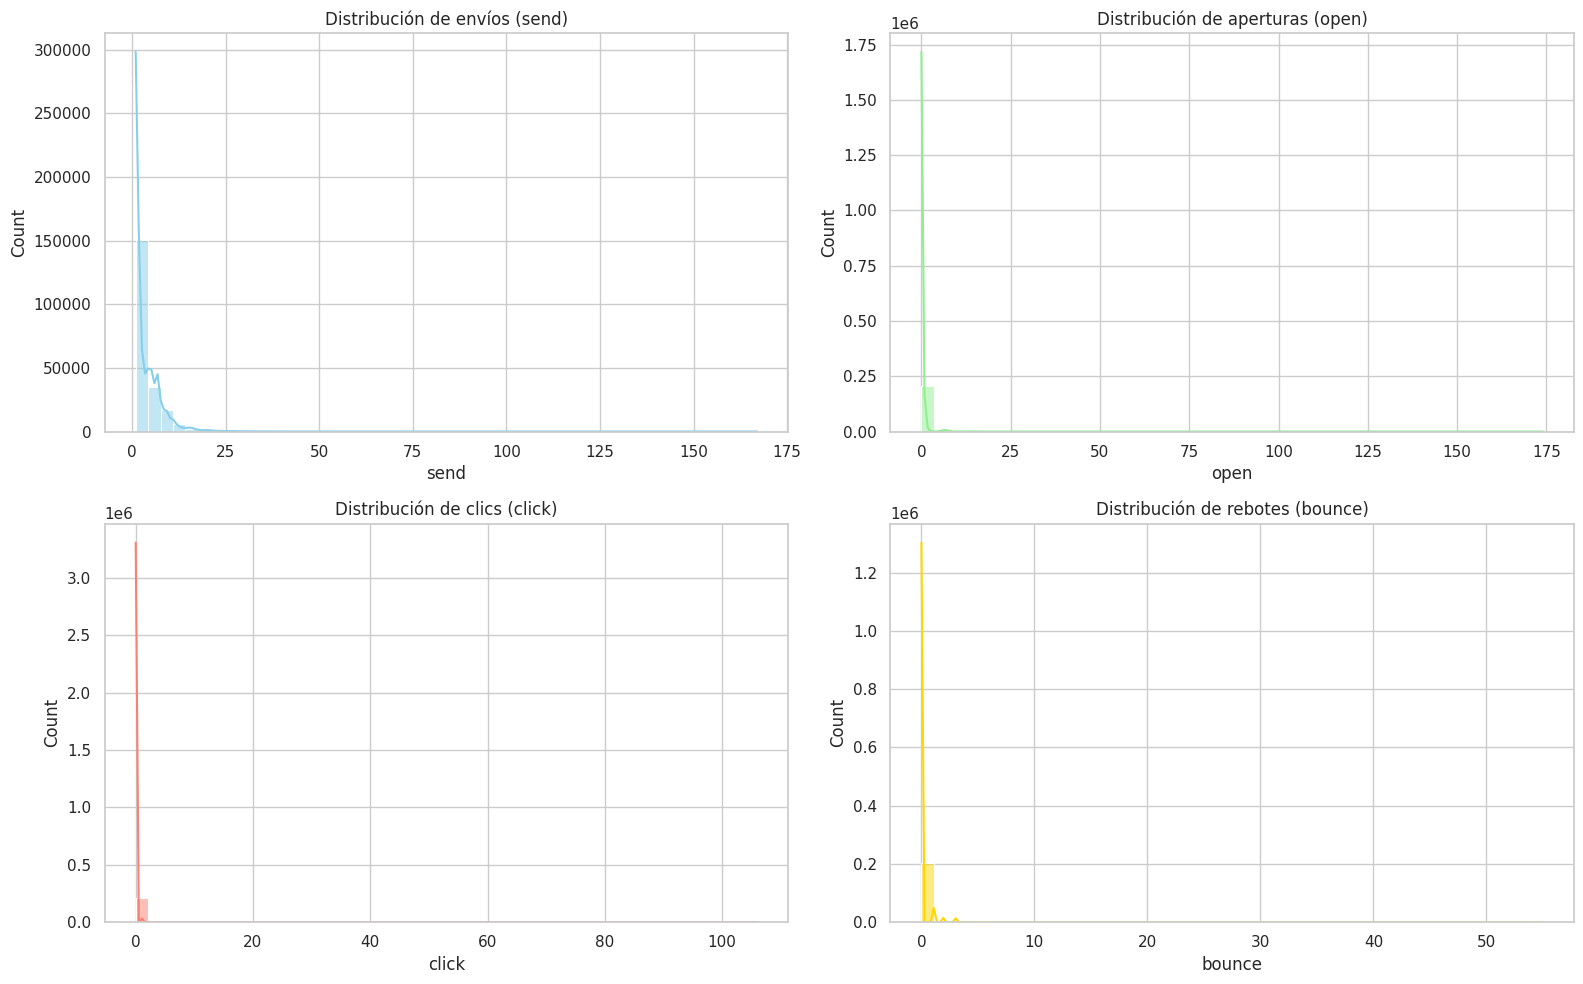

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

sns.histplot(df["send"], bins=50, ax=axs[0, 0], kde=True, color="skyblue")
axs[0, 0].set_title("Distribución de envíos (send)")

sns.histplot(df["open"], bins=50, ax=axs[0, 1], kde=True, color="lightgreen")
axs[0, 1].set_title("Distribución de aperturas (open)")

sns.histplot(df["click"], bins=50, ax=axs[1, 0], kde=True, color="salmon")
axs[1, 0].set_title("Distribución de clics (click)")

sns.histplot(df["bounce"], bins=50, ax=axs[1, 1], kde=True, color="gold")
axs[1, 1].set_title("Distribución de rebotes (bounce)")

plt.tight_layout()
plt.show()

 Dado que hay muchos valores bajos y pocos valores extremos, vemos que lo ideal es usar una escala logarítmica en el eje X para visualizar mejor la distribución.

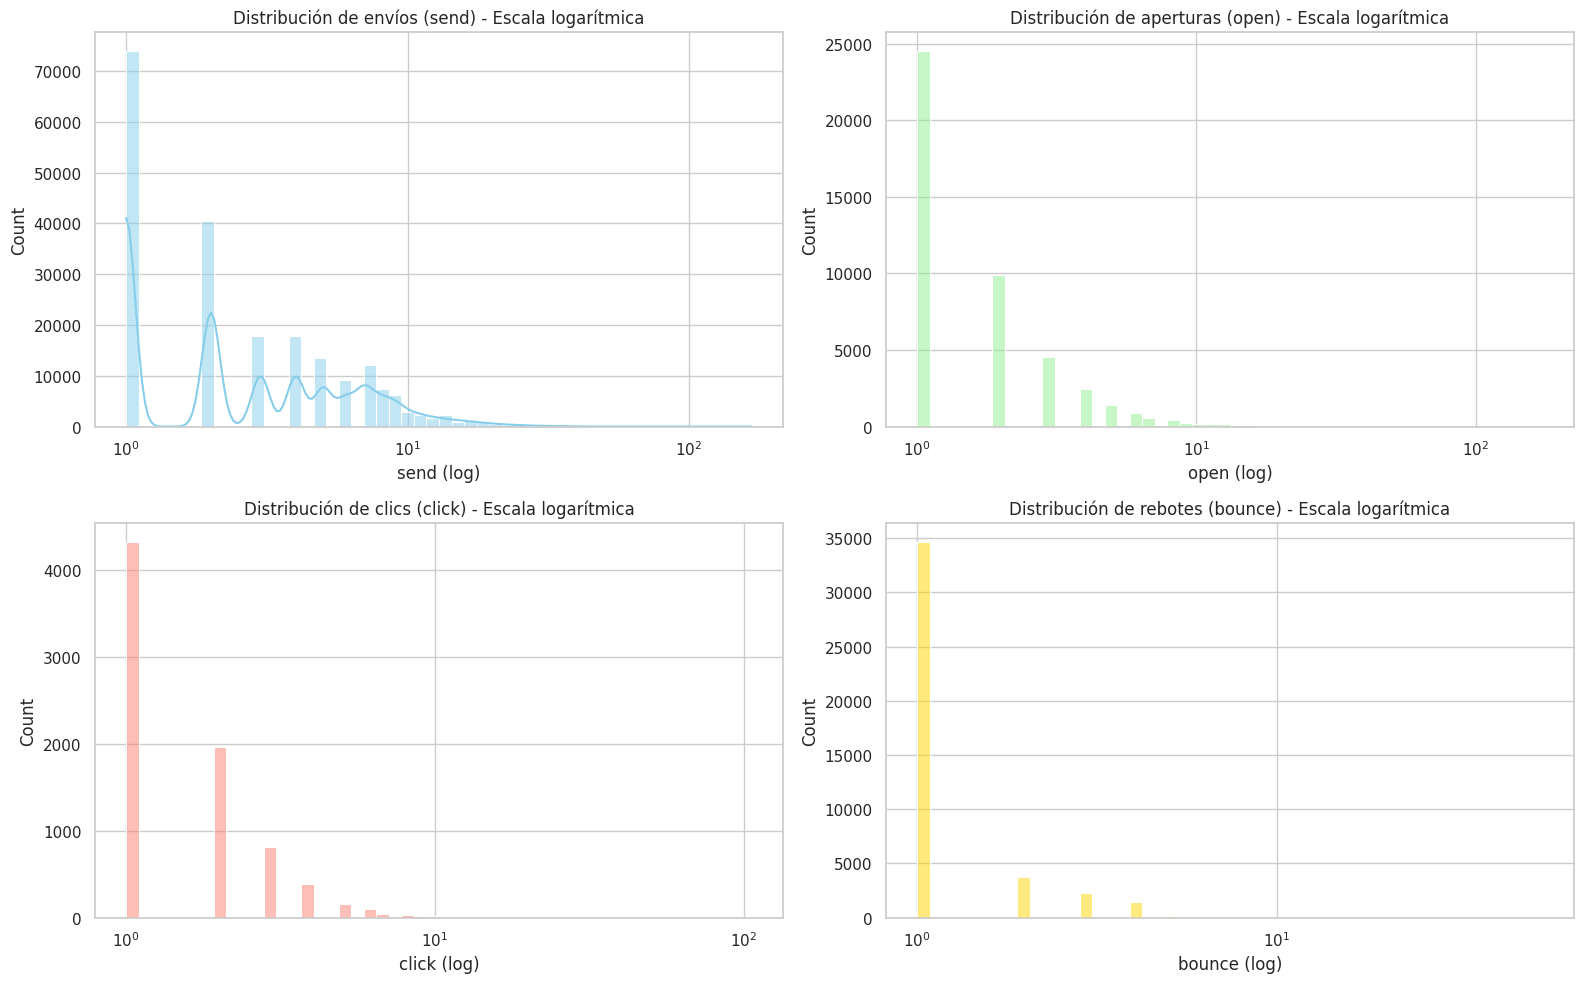

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

sns.histplot(df["send"], bins=50, ax=axs[0, 0], kde=True, color="skyblue", log_scale=(True, False))
axs[0, 0].set_title("Distribución de envíos (send) - Escala logarítmica")
axs[0, 0].set_xlabel("send (log)")

sns.histplot(df["open"], bins=50, ax=axs[0, 1], kde=True, color="lightgreen", log_scale=(True, False))
axs[0, 1].set_title("Distribución de aperturas (open) - Escala logarítmica")
axs[0, 1].set_xlabel("open (log)")

sns.histplot(df["click"], bins=50, ax=axs[1, 0], kde=True, color="salmon", log_scale=(True, False))
axs[1, 0].set_title("Distribución de clics (click) - Escala logarítmica")
axs[1, 0].set_xlabel("click (log)")

sns.histplot(df["bounce"], bins=50, ax=axs[1, 1], kde=True, color="gold", log_scale=(True, False))
axs[1, 1].set_title("Distribución de rebotes (bounce) - Escala logarítmica")
axs[1, 1].set_xlabel("bounce (log)")

plt.tight_layout()
plt.show()

Interpretación de gráficos exploratorios

- send: la mayoría de los usuarios recibieron pocos correos, aunque hay algunos con muchos envíos (cola derecha larga).
- open y click: la mayoría no interactuó (muchos ceros), y hay unos pocos usuarios con alta interacción.
- bounce: casi todos tienen rebotes nulos, con muy pocos casos extremos.

Estas distribuciones sugieren una gran concentración de usuarios poco activos y algunos usuarios muy comprometidos, lo cual es ideal para segmentar.

🔗 Matriz de correlación entre variables

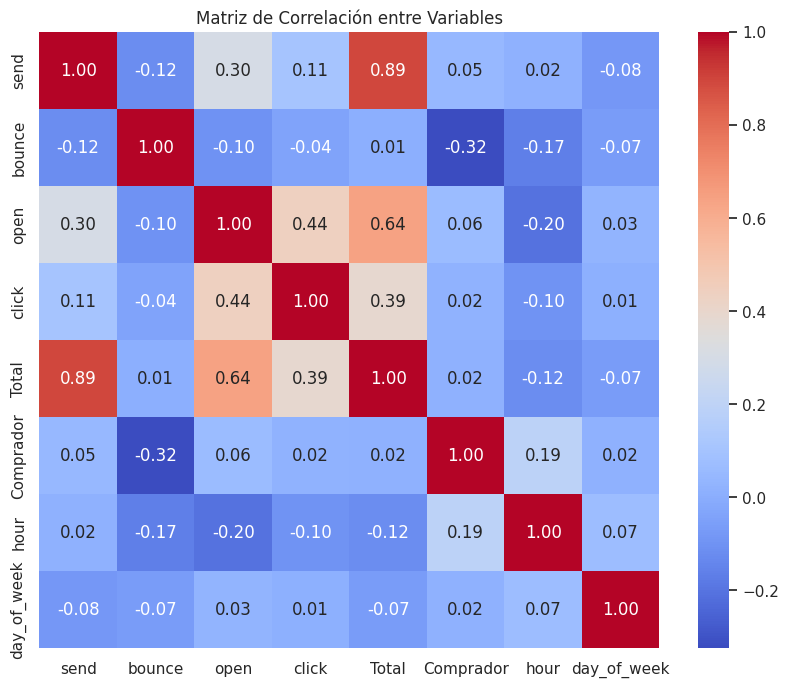

In [ ]:
correlation_matrix = df.drop(columns=["Id"]).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación entre Variables")
plt.show()

Interpretación matriz de correlación

- Hay fuerte correlación entre send, open y click, lo que sugiere que los usuarios más expuestos tienden a interactuar más.
- bounce tiene baja correlación con el resto, indicando un comportamiento más independiente.

🛍️ Distribución de la variable target Comprador

/tmp/ipython-input-858431609.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Comprador", data=df, palette="pastel")


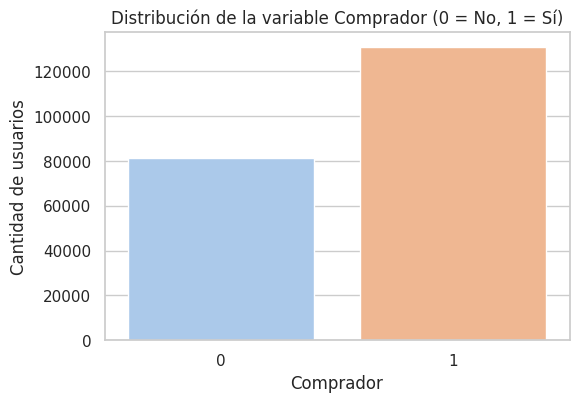

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x="Comprador", data=df, palette="pastel")
plt.title("Distribución de la variable Comprador (0 = No, 1 = Sí)")
plt.xlabel("Comprador")
plt.ylabel("Cantidad de usuarios")
plt.show()

Interpretación

- La variable Comprador muestra que la mayoría de los usuarios realizaron al menos una compra (Comprador = 1). Esto sugiere que la base de datos incluye un alto porcentaje de clientes activos o efectivos, lo cual es un buen indicio del desempeño de las campañas o de la calidad del dataset.
- Esto puede ser útil para interpretar si algún cluster tiene mayor proporción de compradores.

⚠️ Verificación de consistencia en la variable Total

In [ ]:
df["Total_calc"] = df["send"] + df["bounce"] + df["open"] + df["click"]
inconsistencias = (df["Total"] != df["Total_calc"]).sum()
print(f"Cantidad de registros inconsistentes en Total: {inconsistencias}")

Cantidad de registros inconsistentes en Total: 15283


Interpretación

- Se detectaron 15.283 filas donde Total no coincide con la suma de send + bounce + open + click.
- Conviene recalcular esta columna o ignorarla y trabajar directamente con las variables originales.

⏰ Distribución de Hora y Día Promedio de Interacción

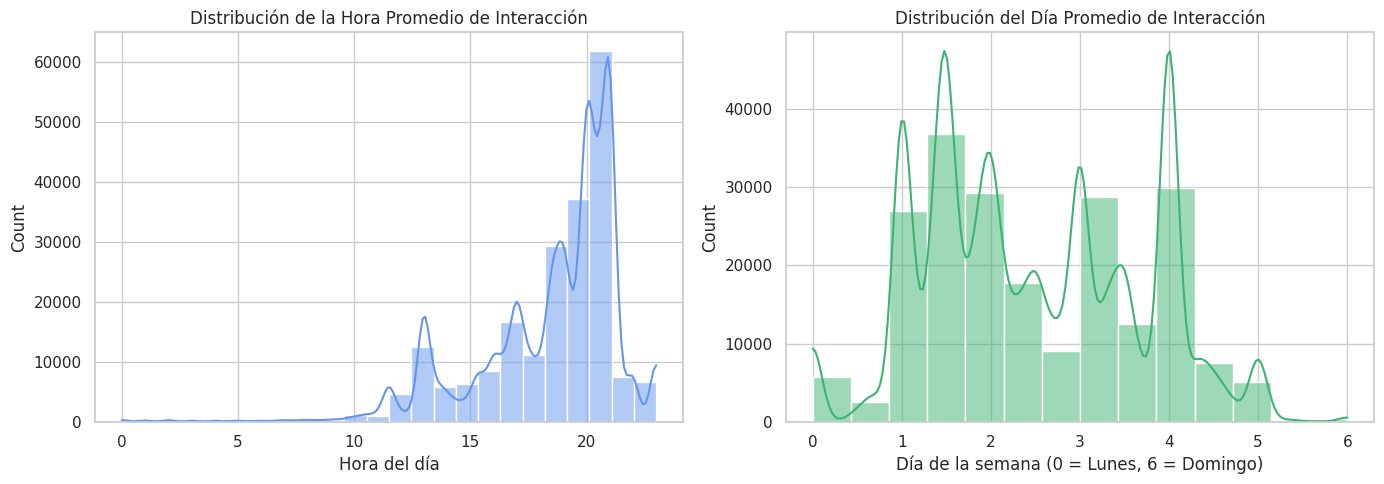

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df["hour"], bins=24, kde=True, ax=axs[0], color="cornflowerblue")
axs[0].set_title("Distribución de la Hora Promedio de Interacción")
axs[0].set_xlabel("Hora del día")

sns.histplot(df["day_of_week"], bins=14, kde=True, ax=axs[1], color="mediumseagreen")
axs[1].set_title("Distribución del Día Promedio de Interacción")
axs[1].set_xlabel("Día de la semana (0 = Lunes, 6 = Domingo)")

plt.tight_layout()
plt.show()

Interpretación

- La hora promedio de interacción muestra picos entre las 16 y 20 hs, coincidiendo con el horario laboral tarde o regreso a casa.
- El día promedio de interacción está centrado en valores entre 2 y 4, es decir entre martes y jueves, días comunes para actividad online y envíos de marketing.

### 2.4 Limpieza, creación de nuevas variables y escalado para clustering

🧪 Crear nuevas variables de comportamiento

El siguiente bloque de código tiene como objetivo crear variables derivadas que capten el comportamiento de los usuarios en términos relativos, y no solo absolutos.

In [ ]:
# evitamos divisiones por cero con una pequeña constante
df["open_rate"] = df["open"] / (df["send"] + 1e-5)
df["click_rate"] = df["click"] / (df["send"] + 1e-5)
df["bounce_rate"] = df["bounce"] / (df["send"] + 1e-5)

# algunas relaciones adicionales
df["click_per_open"] = df["click"] / (df["open"] + 1e-5)
df["interactions"] = df["open"] + df["click"]

¿Por qué sumar 1e-5?

1e-5 es una constante muy pequeña (0.00001) que se suma al denominador para evitar errores de división por cero.

✅ Variables creadas

- open_rate -> mide proporción de correos abiertos sobre los enviados

- click_rate -> mide proporción de clicks sobre los correos enviados

- bounce_rate -> mide proporción de correos rebotados.

- click_per_open -> mide cuántos clicks se hacen por apertura.

- interactions -> mide suma bruta de interacciones.

In [ ]:
# verificamos que se hayan creado las nuevas variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212292 entries, 0 to 212291
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Id              212292 non-null  int64  
 1   send            212292 non-null  int64  
 2   bounce          212292 non-null  int64  
 3   open            212292 non-null  int64  
 4   click           212292 non-null  int64  
 5   Total           212292 non-null  int64  
 6   Comprador       212292 non-null  int64  
 7   hour            212292 non-null  float64
 8   day_of_week     212292 non-null  float64
 9   Total_calc      212292 non-null  int64  
 10  open_rate       212292 non-null  float64
 11  click_rate      212292 non-null  float64
 12  bounce_rate     212292 non-null  float64
 13  click_per_open  212292 non-null  float64
 14  interactions    212292 non-null  int64  
dtypes: float64(6), int64(9)
memory usage: 24.3 MB


🧼 Eliminar columnas que no serán utilizadas directamente

In [ ]:
# como la variable "Total" no es confiable, podemos eliminarla junto a "Id" y "Total_calc"
df.drop(columns=["Id", "Total", "Total_calc"], inplace=True, errors="ignore")

⚖️ Escalado de variables para clustering (MinMaxScaler)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# seleccionamos variables numéricas a usar para clustering
features = [
    "send", "open", "click", "bounce",
    "hour", "day_of_week",
    "open_rate", "click_rate", "bounce_rate", "click_per_open", "interactions"
]

# escalamos con MinMaxScaler (valores entre 0 y 1)
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[features])

# convertimos a DataFrame escalado
df_cluster = pd.DataFrame(df_scaled, columns=features)
df_cluster.head()

,send,open,click,bounce,hour,day_of_week,open_rate,click_rate,bounce_rate,click_per_open,interactions
0,0.018072,0.000000,0.0,0.0,0.739130,0.583333,0.000000,0.0,0.0,0.0,0.000000
1,0.000000,0.000000,0.0,0.0,0.913043,0.666667,0.000000,0.0,0.0,0.0,0.000000
2,0.018072,0.000000,0.0,0.0,0.739130,0.583333,0.000000,0.0,0.0,0.0,0.000000
3,0.012048,0.000000,0.0,0.0,0.666667,0.555556,0.000000,0.0,0.0,0.0,0.000000
4,0.042169,0.005747,0.0,0.0,0.792271,0.333333,0.003099,0.0,0.0,0.0,0.003584


🧠 ¿Por qué escalar antes de clustering?

Antes de aplicar el algoritmo de clustering, es fundamental escalar las variables numéricas.

Esto se debe a que algoritmos como K-Means se basan en la distancia euclidiana. Si las variables tienen escalas distintas (por ejemplo, `send` puede ir hasta 170, mientras que `click_rate` está entre 0 y 0.3), los resultados del clustering estarían sesgados por las variables de mayor magnitud.

Para evitarlo, utilizamos **MinMaxScaler**, que transforma todas las variables al rango [0, 1], preservando su distribución relativa. Esto asegura que todas las variables contribuyan equitativamente a la formación de los clusters.

Si no escalamos, por ejemplo interactions va a dominar completamente las distancias → el clustering va a estar sesgado.



Con esto ya tenemos los datos preparados para el clustering.

## 3. Selección del número óptimo de clusters y entrenamiento del modelo


Scikit-Learn tiene una implementación del método que utilizaremos llamado K-Means.

Utilizaremos dos métricas para evaluar la calidad de los clusters:
- Inercia (inertia)
- Silueta (silhouette)

Inercia

Vamos a evaluar las particiones que realizamos mediante K-Means utilizando la inercia. La idea es que al variar el número de clúster K en el modelo, el valor de la distancia media de los datos al centroide más cercano va a variar. Queremos graficar esa curva para elegir el número de particiones óptimos con el metodo del codo.


Silueta

Vamos a evaluar las particiones que realizamos mediante el valor de silhouette.

Calcularemos el valor de silhouette promedio para distintos valores de K. La manera de hacerlo es igual a la que usamos para calcular los valores de inercia, vamos a recorrer con un for los distintos modelos e ir agregando a una lista los valores. Esta vez, en lugar de calcular la inercia, vamos a calcular el valor de silhouette usando la función silhouette_score.

Lo óptimo sería que le métrica se acerque a 1 y se aleje de -1.

❓ ¿Por qué utilizamos K Means y no DB Scan?

Aunque existen múltiples algoritmos de clustering, en este trabajo se utilizó K-Means por las siguientes razones:

- Es eficiente y escalable para datasets grandes como el actual (+200.000 registros).
- Permite definir y analizar un número específico de grupos (`k`), como requería la consigna.
- Se adapta bien cuando los grupos esperados son compactos y esféricos, como se da en comportamientos de usuarios con distintas tasas de interacción.
- Es más simple de interpretar y ajustar que otros métodos como DB SCAN.

DB SCAN, si bien útil en otras situaciones, puede tener dificultades en alta dimensión, es sensible a la elección de parámetros (`eps`, `min_samples`) y puede generar muchos puntos considerados "ruido" u outliers, lo que no era lo ideal para este análisis centrado en segmentación clara y aplicable.


### 3.1 Código para el método del codo y silueta

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# evaluaremos entre 2 y 10 clusters
inertias = [] # inercia
silhouettes = [] # silueta
K_range = range(2, 11) # entre 2 y 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_cluster)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(df_cluster, kmeans.labels_))

In [ ]:
# n_init=10 -> indica cuántas veces se ejecutará el algoritmo con diferentes centroides iniciales, y luego se quedará con
# la mejor solución (la de menor inercia). Es decir, prueba 10 inicializaciones diferentes y se queda con la mejor

📈 Visualización del método del codo

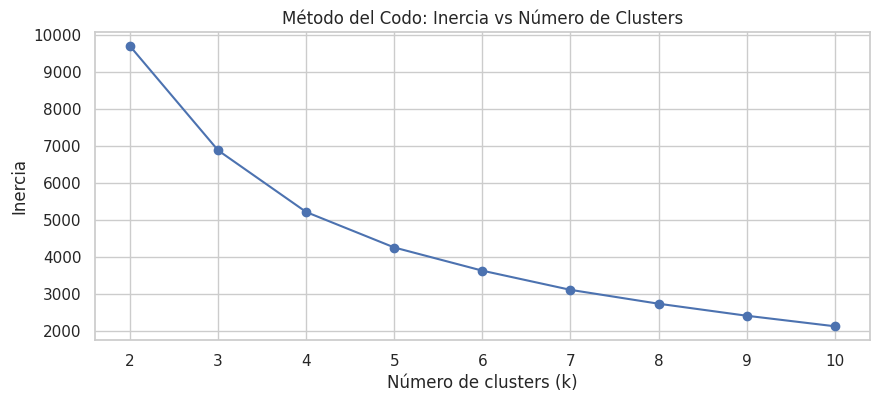

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(K_range, inertias, marker='o')
plt.title("Método del Codo: Inercia vs Número de Clusters")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")
plt.grid(True)
plt.show()

🧪 Visualización del coeficiente de silueta

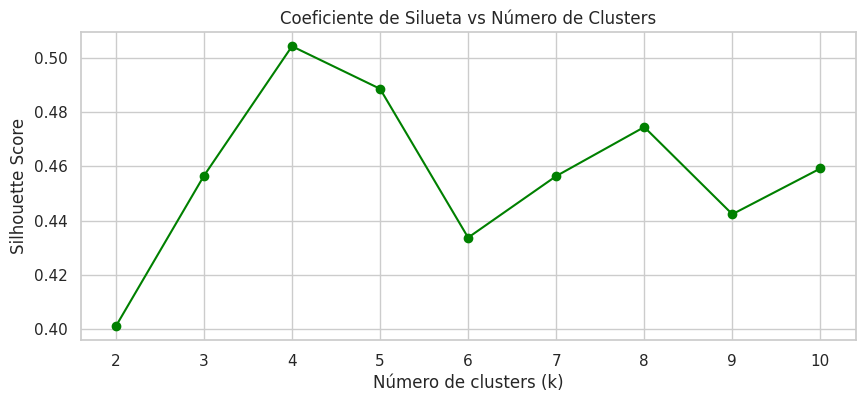

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(K_range, silhouettes, marker='o', color='green')
plt.title("Coeficiente de Silueta vs Número de Clusters")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

Recomendación de número óptimo de clusters:

📉 Método del codo
- El “codo” más claro está en k = 4 -> A partir de ahí, la inercia sigue bajando pero mucho más lento.

- Por lo tanto, k=4 es un punto razonable donde se logra buen equilibrio entre simplicidad y compactación.

📈 Coeficiente de silueta

- El valor máximo también se da en k = 4 (~0.505), lo cual refuerza esa elección.

🟢 Conclusión:

Elegimos k = 4 como número óptimo de clusters.

Esto indica que el dataset puede segmentarse de forma natural en 4 grupos con diferencias internas claras.


### 3.2 Entrenar modelo final con el valor óptimo de k

In [ ]:
# definir y entrenar modelo final
k_optimo = 4
kmeans_final = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
df["cluster"] = kmeans_final.fit_predict(df_cluster)

## 4. Análisis y caracterización de los clusters

El objetivo es entender cómo se comporta cada grupo y qué los diferencia, para luego pensar aplicaciones reales (por ejemplo, segmentación para campañas de marketing).

📊 Estadísticas descriptivas por cluster

In [ ]:
# agrupar por cluster y calcular promedios
cluster_summary = df.groupby("cluster").agg({
    "send": "mean",
    "open": "mean",
    "click": "mean",
    "bounce": "mean",
    "hour": "mean",
    "day_of_week": "mean",
    "open_rate": "mean",
    "click_rate": "mean",
    "bounce_rate": "mean",
    "click_per_open": "mean",
    "interactions": "mean",
    "Comprador": ["mean", "count"]  # proporción y tamaño del cluster
})

# renombrar columnas para claridad
cluster_summary.columns = ['_'.join(col).strip() for col in cluster_summary.columns.values]
cluster_summary.reset_index(inplace=True)
cluster_summary

,cluster,send_mean,open_mean,click_mean,bounce_mean,hour_mean,day_of_week_mean,open_rate_mean,click_rate_mean,bounce_rate_mean,click_per_open_mean,interactions_mean,Comprador_mean,Comprador_count
0,0,5.227887,0.562772,0.077679,0.043264,19.208331,1.556873,0.132260,0.019114,0.012418,542.623516,0.640451,0.745237,90861
1,1,3.292389,0.584060,0.088889,0.020148,18.604540,3.643360,0.223166,0.036834,0.007723,377.741843,0.672949,0.692676,80752
2,2,1.356771,0.208530,0.051277,1.073157,12.531197,1.405962,0.088281,0.023707,0.910182,289.177768,0.259807,0.164145,20750
3,3,1.441116,0.004315,0.000401,1.418887,21.126119,2.956385,0.001054,0.000121,0.994809,5.018049,0.004717,0.192333,19929


📉 Visualización comparativa de clusters

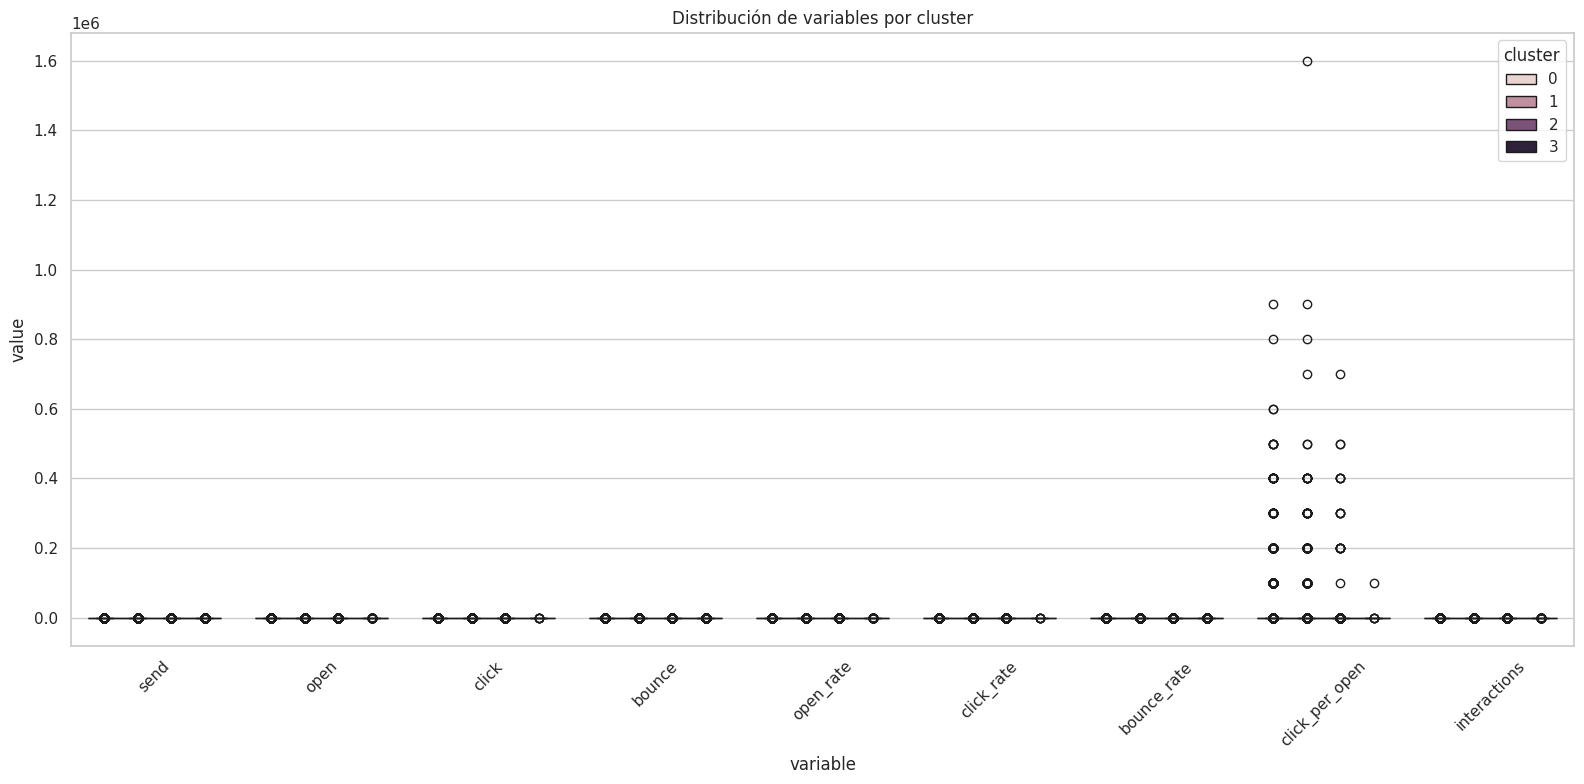

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# transformar a formato largo para graficar
df_melted = df[[
    "cluster", "send", "open", "click", "bounce",
    "open_rate", "click_rate", "bounce_rate",
    "click_per_open", "interactions"
]].melt(id_vars="cluster")

# boxplot comparativo
plt.figure(figsize=(16, 8))
sns.boxplot(data=df_melted, x="variable", y="value", hue="cluster")
plt.xticks(rotation=45)
plt.title("Distribución de variables por cluster")
plt.tight_layout()
plt.show()

Interpretación

El gráfico es correcto en cuanto al código, pero la escala está distorsionada por los valores extremos de una o más variables. Por ejemplo, la variable interactions tiene valores muchos más altos que otras.

Aplicaremos escala logarítmica para mejorar la visualización.

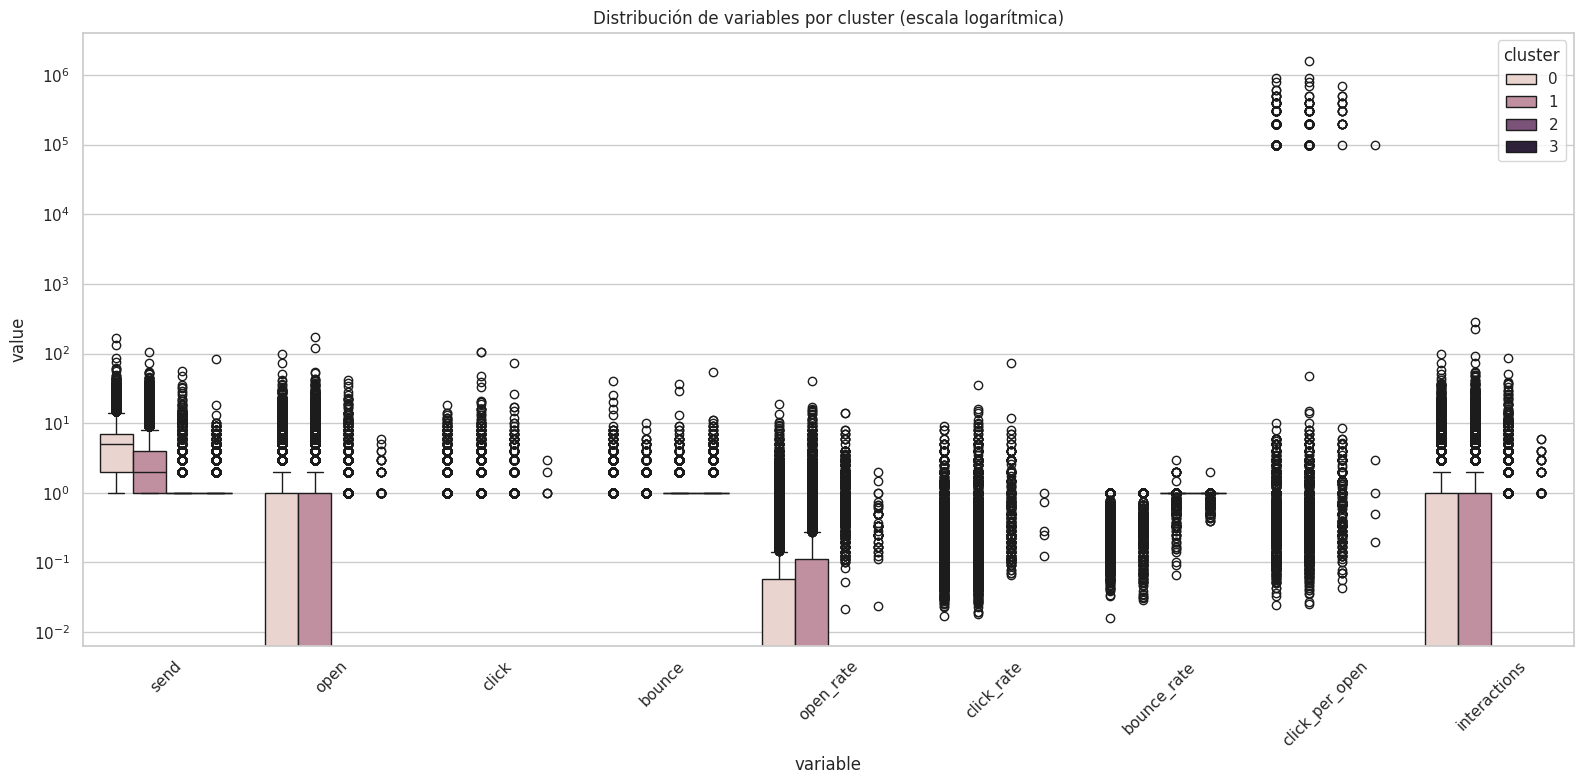

In [ ]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=df_melted, x="variable", y="value", hue="cluster")
plt.yscale("log")  # Escala logarítmica
plt.xticks(rotation=45)
plt.title("Distribución de variables por cluster (escala logarítmica)")
plt.tight_layout()
plt.show()

🧩 Análisis de los 4 clusters

A continuación se describen las principales características y comportamientos observados en cada grupo resultante del clustering:

---

🔹 Cluster 0 – Activos moderados con alta conversión
- **Tamaño**: 90.861 usuarios (~34%)
- **Envíos promedio**: 5.2
- **Tasa de apertura**: 13%
- **Tasa de clic**: 1.9%
- **Compradores**: 64%
- **Interacciones promedio**: 543

**Interpretación**:  
Usuarios con comportamiento equilibrado: abren y hacen clic con cierta frecuencia. Buen nivel de conversión. El engagement no es extremo, pero **aportan mucho valor** al negocio.

---

🔹 Cluster 1 – Altamente comprometidos
- **Tamaño**: 80.752 usuarios (~30%)
- **Envíos promedio**: 3.3
- **Tasa de apertura**: 22%
- **Tasa de clic**: 3.7%
- **Compradores**: 67%
- **Interacciones promedio**: 378

**Interpretación**:  
Usuarios **muy activos y comprometidos**, aunque reciben menos correos. Alta tasa de apertura y clic. Son el **grupo más atractivo para acciones de marketing personalizadas o intensivas**.

---

🔹 Cluster 2 – Rebotes altos, baja conversión
- **Tamaño**: 20.750 usuarios (~8%)
- **Tasa de rebote**: 91%
- **Tasa de apertura**: 8.8%
- **Tasa de clic**: 2.3%
- **Compradores**: 26%
- **Interacciones promedio**: 289

**Interpretación**:  
Cuentas con posibles problemas de entrega (emails inválidos, bandejas llenas). Poca interacción y bajo nivel de conversión. Grupo de **riesgo bajo** o con datos desactualizados.

---

🔹 Cluster 3 – Inactivos totales
- **Tamaño**: 19.929 usuarios (~7%)
- **Tasa de apertura**: prácticamente 0%
- **Tasa de clic**: casi 0%
- **Tasa de rebote**: 99%
- **Compradores**: 0.47%
- **Interacciones promedio**: 5

**Interpretación**:  
Usuarios completamente inactivos, con altísimos rebotes. No abren ni hacen clic en correos. No generan compras. Este grupo **no aporta valor** y debería ser descartado o segmentado para estrategias de recuperación.

---

## 5. Recomendaciones para el equipo de marketing

A partir del análisis de los clusters, se proponen las siguientes acciones estratégicas adaptadas a los distintos perfiles de usuarios identificados:

---

🟡 Cluster 0 – Usuarios con buen comportamiento general
- **Recomendación**: Mantener el contacto y reforzar el vínculo con contenido relevante.
- **Acciones sugeridas**:
  - Incentivar clics con promociones atractivas.
  - Automatizar seguimientos post-interacción.
  - Segmentar por horario/día más activo para optimizar tasas de apertura.

---

🟢 Cluster 1 – Usuarios altamente comprometidos
- **Recomendación**: Priorizar este grupo en campañas promocionales personalizadas.
- **Acciones sugeridas**:
  - Ofertas exclusivas o anticipadas.
  - Envíos frecuentes con contenido personalizado.
  - Cross-selling y up-selling (productos relacionados o premium).

---

🔴 Cluster 2 – Rebotes elevados y bajo rendimiento
- **Recomendación**: Revisar calidad de los datos de contacto.
- **Acciones sugeridas**:
  - Validar correos electrónicos (limpieza de base).
  - Incluir en campañas de reactivación o “última oportunidad”.
  - Evitar sobrecargar con nuevos envíos sin revisión previa.

---

⚫ Cluster 3 – Usuarios completamente inactivos
- **Recomendación**: Excluir de campañas regulares. Enviar una última campaña de recuperación o limpieza.
- **Acciones sugeridas**:
  - Email de reenganche con incentivo fuerte (descuento único, encuesta).
  - Si no hay respuesta, depurar del mailing.
  - Considerar contacto por otro canal (ej. redes sociales, teléfono).

---

Estas recomendaciones permiten al equipo de marketing **optimizar recursos**, mejorar la tasa de respuesta y reducir rebotes, alineando las campañas a perfiles reales de comportamiento.

## 6. Conclusión Final

A lo largo del trabajo se aplicaron técnicas de clustering para segmentar usuarios en base a su comportamiento frente a campañas de mailing.

Se partió de un análisis exploratorio detallado, se crearon nuevas variables relevantes (como tasas de apertura y click), y se aplicaron métodos para determinar la cantidad óptima de grupos. Finalmente, se entrenó un modelo de clustering (K-Means) y se identificaron **4 perfiles de usuarios claramente diferenciados**:

- **Cluster 0**: Segmento equilibrado, con buena tasa de conversión. Merecen un contacto sostenido.
- **Cluster 1**: Usuarios altamente comprometidos, con excelente tasa de apertura y conversión. Representan el público más valioso.
- **Cluster 2**: Usuarios con alta tasa de rebote. Sugieren problemas técnicos o pérdida de interés.
- **Cluster 3**: Usuarios completamente inactivos, sin interacción. Bajo valor actual.

Esta segmentación permite al equipo de marketing **tomar decisiones más informadas**, optimizar recursos y diseñar estrategias diferenciadas para cada grupo. Además, muestra el valor que puede aportar el análisis de datos en la mejora de las campañas de comunicación.

En futuras extensiones del análisis, podrían aplicarse técnicas como modelos predictivos de conversión, análisis temporal de interacción o pruebas A/B sobre campañas adaptadas a cada cluster.

🎯 ¿Qué son los sistemas de recomendación y porque no lo aplicamos en este clustering?

- Filtrado colaborativo: recomienda productos basándose en comportamientos similares entre usuarios (ej: "los que compraron X también compraron Y").

- Filtrado basado en contenido: recomienda según las características del usuario o del producto (ej: "te recomiendo esto porque se parece a lo que te gustó").


Aunque este trabajo se centró en segmentación por comportamiento ante campañas de mailing, un paso posterior posible sería la aplicación de sistemas de recomendación.

Por ejemplo:
- A los usuarios clasificados como compradores frecuentes (Clusters 0 y 1), se les podría ofrecer recomendaciones personalizadas de productos.
- Si se cuenta con el historial de compras, se podrían aplicar técnicas de:
  - **Filtrado colaborativo**: recomendar productos similares a los que otros usuarios del mismo cluster compraron.
  - **Filtrado basado en contenido**: recomendar productos similares a los ya comprados, según atributos del producto.

Esto permitiría combinar la segmentación con la personalización, aumentando así el impacto de futuras campañas.